# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [1]:
#Imports 
import json
import requests
import pandas as pd
from tqdm import tqdm
import numpy as np
import pprint as pp
from scipy import stats
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import regex as re
import yaml
import tweepy
import sys



In [2]:

urls = []
urls.append('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/59a4e958_twitter-archive-enhanced/twitter-archive-enhanced.csv')
urls.append('https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv')



2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
for url in urls:    
    r = requests.get(url) 
    fn_idx = len(url) - url[::-1].find('/')    
    with open(url[fn_idx:],'wb') as file:
        file.write(r.content)

In [4]:
#import both files into dataframes

df_image_predict = pd.read_csv('image-predictions.tsv',sep='\t')
df_archive_en = pd.read_csv('twitter-archive-enhanced.csv')


In [5]:
display(df_archive_en.info())
display(df_image_predict.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


None

3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [6]:
#Read keys and tokens from config.yaml:


with open(r'config.yaml') as file:
    config = yaml.full_load(file)

consumer_key = config['consumer_key']
consumer_secret = config['consumer_secret']

  

In [7]:
#create tweetpy instance

access_secret = ''
access_token = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
print(access_secret, access_token)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)


The two existing datasets do not have the same number of tweet IDs.
Check to see if the shorter series of IDs (df_image_predict[tweet_id']) is a subset of the longer (df_archive_en['tweet_id'])  

In [8]:
assert set(df_image_predict.tweet_id).issubset(set(df_archive_en.tweet_id))
df_archive_en.tweet_id.shape[0] - df_image_predict.tweet_id.shape[0]

281

In [9]:
#download and store the tweets

json_dicts = []
icount = 0
tweep_errs = {}
for _ in tqdm(df_archive_en.tweet_id, desc="Retrieving tweets...", file=sys.stdout):
    icount += 1    
    try:
        json_dicts.append(dict(api.get_status(_)._json))
    except tweepy.TweepError as e:  
        err = e.args[0][0] 
        tweep_errs[_] = err
#    if (icount == 100): break

with open(r'tweet_json.txt','w') as file:
     file.writelines(json.dumps(json_dicts))




Retrieving tweets...:  64%|███████████████████████████████████▋                    | 1503/2356 [08:27<04:41,  3.03it/s]

Rate limit reached. Sleeping for: 391


Retrieving tweets...: 100%|████████████████████████████████████████████████████████| 2356/2356 [19:44<00:00,  1.99it/s]


In [10]:
# #Check to see what kinds of errors we got... 
df_errs = pd.DataFrame(tweep_errs).transpose()
df_errs.message.value_counts()


No status found with that ID.                        27
Sorry, that page does not exist.                      1
Sorry, you are not authorized to see this status.     1
Name: message, dtype: int64

In [11]:
#Read the stored tweets from file and put them in a dataframe with variables 'id', 'retweet_count', 'favorite_count'

json_list = []
df_tweet_json = pd.read_json('tweet_json.txt')
df_tweet_json.columns
df_tweet_json = df_tweet_json[['id', 'retweet_count', 'favorite_count']]
df_tweet_json.sample(25)

,id,retweet_count,favorite_count
1359,700505138482569216,530,2133
1088,732585889486888962,719,3390
1922,673686845050527744,383,1287
702,783085703974514689,2041,7802
807,768609597686943744,1117,3891
1996,671882082306625538,1232,3138
1174,716439118184652801,194,2225
1798,676430933382295552,307,1276
832,763956972077010945,50,736
926,751793661361422336,2659,5468


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



### Accessing df_archive_en (of provided dataset twitter-archive-enhanced.csv):

In [12]:
df_archive_en.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1131,728986383096946689,NaN,NaN,2016-05-07 16:34:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Puff. He started out on the streets (f...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/728986383...,11,10,Puff,None,None,None,None
2034,671743150407421952,NaN,NaN,2015-12-01 17:30:22 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a Tuscaloosa Alcatraz named Jacob (Yac...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671743150...,11,10,a,None,None,None,None
853,765371061932261376,NaN,NaN,2016-08-16 02:14:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Louie. He's had a long day. Did a lot ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/765371061...,11,10,Louie,None,None,pupper,None
49,882762694511734784,NaN,NaN,2017-07-06 00:46:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Gus. He's quite the cheeky pupper. Alr...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/882762694...,12,10,Gus,None,None,pupper,None
2107,670465786746662913,NaN,NaN,2015-11-28 04:54:34 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Silly dog here. Wearing bunny ears. Nice long ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670465786...,7,10,None,None,None,None,None
1307,707315916783140866,NaN,NaN,2016-03-08 21:23:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Finnegus. He's trapped in a snow globe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/707315916...,10,10,Finnegus,None,None,pupper,None
851,765669560888528897,NaN,NaN,2016-08-16 22:00:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tove. She's a Balsamic Poinsetter. Sur...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/765669560...,12,10,Tove,None,None,None,None
649,792913359805018113,NaN,NaN,2016-10-31 02:17:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a perfect example of someone who has t...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/792913359...,13,10,a,None,None,None,None
1105,734912297295085568,NaN,NaN,2016-05-24 01:02:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Jax. He's a literal fluffball. Sneaky ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/734912297...,10,10,Jax,None,None,None,None
1455,695409464418041856,NaN,NaN,2016-02-05 00:51:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bob. He just got back from his job int...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/695409464...,10,10,Bob,None,None,None,None


In [13]:
df_archive_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [14]:
#Check for duplicates
df_archive_en.drop(columns=['timestamp']).duplicated().sum()

0

In [15]:
#Investigating the meaning of retweeted_ids
retweeted_ids = df_archive_en.retweeted_status_id.apply(lambda _: format(_, '.0f'))
(retweeted_ids != 'nan').sum()



181

In [16]:
#Look for tweets with missing ratings
display(df_archive_en.rating_numerator.sort_values())
display(df_archive_en.rating_denominator.sort_values())


315        0
1016       0
2335       1
2261       1
2338       1
        ... 
2074     420
188      420
189      666
313      960
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

313       0
2335      2
516       7
1576     10
1575     10
       ... 
1635    110
1779    120
1634    130
902     150
1120    170
Name: rating_denominator, Length: 2356, dtype: int64

In [17]:
#checking the meaning of user retweeted id
#comparing IDs here https://tweeterid.com/ 
retweeted_user_ids = df_archive_en.retweeted_status_user_id.apply(lambda _: format(_, '.0f'))
retweeted_user_ids[(retweeted_user_ids != 'nan')].value_counts()

4196983835            156
4296831739              2
512804507               1
712457247234756608      1
783214                  1
280479778               1
195036846               1
1732729088              1
1228325660              1
79923701                1
24885566                1
487197737               1
44667502                1
726634734               1
154767397               1
19607400                1
41198418                1
597064155               1
341021133               1
747554344434831360      1
66699013                1
58709723                1
363890752               1
787461778435289088      1
811740824               1
Name: retweeted_status_user_id, dtype: int64

In [18]:
#checking the consistency of the rating system...
df_archive_en[['rating_numerator', 'rating_denominator']].value_counts()

rating_numerator  rating_denominator
12                10                    558
11                10                    463
10                10                    461
13                10                    351
9                 10                    156
8                 10                    102
7                 10                     54
14                10                     54
5                 10                     37
6                 10                     32
3                 10                     19
4                 10                     15
2                 10                      9
1                 10                      8
420               10                      2
15                10                      2
0                 10                      2
9                 11                      2
4                 20                      2
75                10                      2
666               10                      1
84                70                   

In [19]:
### Accessing df_image_predict:

In [20]:
df_image_predict.sample(20)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1883,847251039262605312,https://pbs.twimg.com/media/C8IKUjAUwAEP-En.jpg,1,Airedale,0.495380,True,Irish_terrier,0.316456,True,Lakeland_terrier,0.158533,True
1576,796080075804475393,https://pbs.twimg.com/media/Cww-msrXcAAxm3K.jpg,1,chow,0.973846,True,Tibetan_mastiff,0.014110,True,gibbon,0.002358,False
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
43,666776908487630848,https://pbs.twimg.com/media/CUDeDoWUYAAD-EM.jpg,1,seat_belt,0.375057,False,miniature_pinscher,0.167175,True,Chihuahua,0.086951,True
1820,834458053273591808,https://pbs.twimg.com/media/C5SXK89XUAQg7GX.jpg,1,Rhodesian_ridgeback,0.468619,True,whippet,0.177531,True,redbone,0.106552,True
1424,772152991789019136,https://pbs.twimg.com/media/Crc9DEoWEAE7RLH.jpg,2,golden_retriever,0.275318,True,Irish_setter,0.100988,True,vizsla,0.073525,True
12,666073100786774016,https://pbs.twimg.com/media/CT5d9DZXAAALcwe.jpg,1,Walker_hound,0.260857,True,English_foxhound,0.175382,True,Ibizan_hound,0.097471,True
297,671390180817915904,https://pbs.twimg.com/media/CVFBzpXVEAAHIOv.jpg,1,zebra,0.997673,False,tiger,0.000837,False,prairie_chicken,0.000575,False
1296,752173152931807232,https://pbs.twimg.com/media/CnBBfNuWcAAkOgO.jpg,1,Labrador_retriever,0.527659,True,German_shepherd,0.174765,True,Chihuahua,0.045525,True
260,670783437142401025,https://pbs.twimg.com/media/CU8Z-OxXAAA-sd2.jpg,1,lacewing,0.381955,False,sulphur_butterfly,0.106810,False,leafhopper,0.068347,False


In [21]:
#Identify duplicate images
df_image_predict.drop(columns='tweet_id').duplicated().sum()


66

In [22]:
#Look for images that have a high probability of containing no dog
df_image_predict_not_dogs = df_image_predict.query('p1_dog == p2_dog == p3_dog == False')
display(df_image_predict_not_dogs.sample(15))
print(f"Not dog count: {df_image_predict_not_dogs.shape[0]}")


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
476,675153376133427200,https://pbs.twimg.com/media/CV6gaUUWEAAnETq.jpg,1,paper_towel,0.327957,False,mailbox,0.096027,False,seat_belt,0.034995,False
618,680221482581123072,https://pbs.twimg.com/media/CXCh0QZW8AALdXm.jpg,1,bubble,0.240173,False,hen,0.146222,False,abaya,0.139342,False
309,671538301157904385,https://pbs.twimg.com/media/CVHIhi2WsAEgdKk.jpg,1,park_bench,0.194211,False,water_bottle,0.071870,False,beacon,0.053433,False
1979,870804317367881728,https://pbs.twimg.com/media/DBW35ZsVoAEWZUU.jpg,1,home_theater,0.168290,False,sandbar,0.098040,False,television,0.079729,False
763,688908934925697024,https://pbs.twimg.com/media/CY9_BOYWkAAkuzn.jpg,1,crane,0.158859,False,pier,0.130016,False,bell_cote,0.087741,False
372,672984142909456390,https://pbs.twimg.com/media/CVbrcZyVAAA5Wpq.jpg,1,wombat,0.738780,False,beaver,0.133368,False,wallaby,0.032370,False
142,668614819948453888,https://pbs.twimg.com/media/CUdloW8WEAAxB_Y.jpg,1,bustard,0.380772,False,pelican,0.100554,False,crane,0.084713,False
1723,819924195358416896,https://pbs.twimg.com/ext_tw_video_thumb/81992...,1,bathtub,0.100896,False,shower_curtain,0.091866,False,tub,0.049176,False
654,682059653698686977,https://pbs.twimg.com/media/CXcpovWWMAAMcfv.jpg,2,jigsaw_puzzle,0.995873,False,Siamese_cat,0.000781,False,pizza,0.000432,False
706,684959798585110529,https://pbs.twimg.com/media/CYF3TSlWMAAaoG5.jpg,1,llama,0.379624,False,triceratops,0.162761,False,hog,0.084251,False


Not dog count: 324


### Quality issues
1. retweeted_status_id's could be self-retweets. This means that any of these 181 records could represent duplicate data. It appears we may be able to identify 'self-retweets' by comparing retweeted_status_user_id

2. The rating scale appears to be inconsistent.

3. The rating scale appears as though it will likely have outliers that will need to be removed for analysis/visualization. Merge into one column as float.

4. There are 281 tweets in **twitter-archive-enhanced** that do not have corrosponding records in **image-predictions.tsv**

5. Some division by 0 in the denominators

6. **source** column should be parsed and categorized. It also requires a meaningful column name. 

7. Drop these columns as they are outside the scope of our analysis: in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id,  retweeted_status_timestamp, expanded_urls

8. Change the following to datatypes: tweet_id: string, timestamp: datetime, source: category, retweeted_status_id: string, retweeted_status_user_id: string, retweeted_status_timestamp: datetime


#### image-predictions
9. There appear to be 66 duplicate images/image predictions. Since image_predictions tweet IDs are a subset of twitter-archive-enhanced tweet IDs, the 66 duplicates in image-predictions will corrospond to tweets in the later set.

10. There are 324 records where no dogs were detected whatsoever.

11. Take the most likely of p1, p2, p3, move it to a new column predicted_breed and drop the others.



### Tidiness issues
#### df_archive_en / twitter-archive-enhanced
1. Merge doggo, floofer, pupper, puppo into one column of type category

2. Merge df_image_predict, df_tweet_json, and df_archive_en into one master clean dataframe

#### df_image_predict / image-predictions


## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [23]:
# Make copies of original pieces of data

df_archive_clean = df_archive_en.copy()
df_predict_clean = df_image_predict.copy()

### Cleanliness Issue #1:
Columns need to be set to appropriate datatypes.

#### Define: 
Change the following to datatypes
- df_archive_clean:
    - tweet_id: string
    - timestamp: datetime
    - source: category
    - retweeted_status_id: string
    - retweeted_status_user_id: string
    - retweeted_status_timestamp: datetime 
    - rating_numerator: float
    - rating_denominator: float
- df_predict_clean:
    - tweet_id: string
- df_tweet_json
    - tweet_id: string
    - retweet_count: int
    - favorite_count: int


#### Code

In [24]:
df_archive_clean['tweet_id'] = df_archive_clean.tweet_id.astype(str)
df_archive_clean['timestamp'] = pd.to_datetime(df_archive_clean.timestamp)
df_archive_clean['source'] = df_archive_clean.source.astype('category')
df_archive_clean['retweeted_status_id'] = df_archive_clean.retweeted_status_id.apply(lambda _: format(_, '.0f'))
df_archive_clean['retweeted_status_user_id'] = df_archive_clean.retweeted_status_user_id.apply(lambda _: format(_, '.0f'))
df_archive_clean['retweeted_status_timestamp'] = pd.to_datetime(df_archive_clean.retweeted_status_timestamp)
df_archive_clean['rating_numerator'] = df_archive_clean['rating_numerator'].astype(float)
df_archive_clean['rating_denominator'] = df_archive_clean['rating_denominator'].astype('float')

In [25]:
df_predict_clean['tweet_id'] = df_predict_clean.tweet_id.astype(str)

In [26]:
df_tweet_json.rename(columns={'id': 'tweet_id'}, inplace=True)
df_tweet_json['tweet_id'] = df_tweet_json.tweet_id.astype(str)
df_tweet_json['favorite_count'] = df_tweet_json.favorite_count.astype('int64')
df_tweet_json['retweet_count'] = df_tweet_json.retweet_count.astype('int64')
#df_tweet_json.favorite_count.sort_values()

#### Test

In [27]:
display(df_archive_clean.info())
display(df_archive_clean.sample(10))
display(df_predict_clean.info())
display(df_predict_clean.sample(5))
display(df_tweet_json.info())
display(df_tweet_json.sample(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2356 non-null   object             
 1   in_reply_to_status_id       78 non-null     float64            
 2   in_reply_to_user_id         78 non-null     float64            
 3   timestamp                   2356 non-null   datetime64[ns, UTC]
 4   source                      2356 non-null   category           
 5   text                        2356 non-null   object             
 6   retweeted_status_id         2356 non-null   object             
 7   retweeted_status_user_id    2356 non-null   object             
 8   retweeted_status_timestamp  181 non-null    datetime64[ns, UTC]
 9   expanded_urls               2297 non-null   object             
 10  rating_numerator            2356 non-null   float64         

None

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
666,790581949425475584,NaN,NaN,2016-10-24 15:53:19+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Duke. He sneaks into the fridge someti...,nan,nan,NaT,https://twitter.com/dog_rates/status/790581949...,11.0,10.0,Duke,None,None,None,None
2196,668852170888998912,NaN,NaN,2015-11-23 18:02:38+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Bobb. Bobb is a Golden High Fescu...,nan,nan,NaT,https://twitter.com/dog_rates/status/668852170...,11.0,10.0,Bobb,None,None,None,None
1939,673887867907739649,NaN,NaN,2015-12-07 15:32:42+00:00,"<a href=""http://twitter.com/download/iphone"" r...",When you're having a great time sleeping and y...,nan,nan,NaT,https://twitter.com/dog_rates/status/673887867...,10.0,10.0,None,None,None,None,None
1399,699691744225525762,NaN,NaN,2016-02-16 20:28:06+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Dave. He's a tropical pup. Short lil l...,nan,nan,NaT,https://twitter.com/dog_rates/status/699691744...,5.0,10.0,Dave,None,None,None,None
594,798705661114773508,NaN,NaN,2016-11-16 01:54:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Baloo. He's expecting a fa...,740676976021798912,4196983835,2016-06-08 22:48:46+00:00,https://twitter.com/dog_rates/status/740676976...,11.0,10.0,Baloo,None,None,pupper,None
1660,683078886620553216,NaN,NaN,2016-01-02 00:14:32+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we see a nifty leaping pupper. Feet look ...,nan,nan,NaT,https://twitter.com/dog_rates/status/683078886...,9.0,10.0,None,None,None,pupper,None
946,752568224206688256,NaN,NaN,2016-07-11 18:20:21+00:00,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",Here are three doggos completely misjudging an...,nan,nan,NaT,https://vine.co/v/5W0bdhEUUVT,9.0,10.0,None,None,None,None,None
706,785533386513321988,NaN,NaN,2016-10-10 17:32:08+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Dallas. Her tongue is ridiculous. 11/1...,nan,nan,NaT,https://twitter.com/dog_rates/status/785533386...,11.0,10.0,Dallas,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,876850772322988032,512804507,2017-06-19 17:14:49+00:00,https://twitter.com/rachel2195/status/87685077...,14.0,10.0,None,None,None,pupper,None
1588,686730991906516992,NaN,NaN,2016-01-12 02:06:41+00:00,"<a href=""http://twitter.com/download/iphone"" r...",I just love this picture. 12/10 lovely af http...,nan,nan,NaT,https://twitter.com/dog_rates/status/686730991...,12.0,10.0,None,None,None,None,None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   object 
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


None

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
280,671115716440031232,https://pbs.twimg.com/media/CVBILUgVAAA1ZUr.jpg,1,malinois,0.406341,True,kelpie,0.143366,True,dingo,0.129802,False
1487,782021823840026624,https://pbs.twimg.com/media/CdHwZd0VIAA4792.jpg,1,golden_retriever,0.383223,True,cocker_spaniel,0.165930,True,Chesapeake_Bay_retriever,0.118199,True
495,675740360753160193,https://pbs.twimg.com/ext_tw_video_thumb/67574...,1,golden_retriever,0.800495,True,kuvasz,0.097756,True,Saluki,0.068415,True
1916,854482394044301312,https://pbs.twimg.com/media/C9u7MtmV0AA741s.jpg,1,Chihuahua,0.260242,True,toy_poodle,0.189158,True,Labrador_retriever,0.144195,True
719,685906723014619143,https://pbs.twimg.com/media/CYTUhn7WkAEXocW.jpg,1,Yorkshire_terrier,0.414963,True,briard,0.063505,True,Pekinese,0.053682,True


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   tweet_id        2327 non-null   object
 1   retweet_count   2327 non-null   int64 
 2   favorite_count  2327 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


None

,tweet_id,retweet_count,favorite_count
1194,714258258790387713,677,2845
908,753375668877008896,2157,7218
463,815639385530101762,1566,7887
1337,702684942141153280,975,3019
577,798694562394996736,4693,0


### Tidiness Issue #1: the 3 primary dataframes should be merged into a single dataframe; df_master

##### Define: Merge them on tweet ID. Will have to correct the name and datatype of df_tweet_json first in this step.

##### Code

In [79]:
df_master = pd.merge(df_archive_clean, df_predict_clean,how='inner', on='tweet_id')
df_master = df_master.merge(df_tweet_json, how="inner", on='tweet_id')
df_master.info()
# df_tweet_json.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2057 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2057 non-null   datetime64[ns, UTC]
 4   source                      2057 non-null   category           
 5   text                        2057 non-null   object             
 6   retweeted_status_id         2057 non-null   object             
 7   retweeted_status_user_id    2057 non-null   object             
 8   retweeted_status_timestamp  71 non-null     datetime64[ns, UTC]
 9   expanded_urls               2057 non-null   object             
 10  rating_numerator            2057 non-null   float64         

##### Test

In [80]:
df_master.info()
assert df_master.columns.shape[0] == (df_archive_clean.columns.shape[0] + df_predict_clean.columns.shape[0] + df_tweet_json.columns.shape[0] - 2)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2057 entries, 0 to 2056
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2057 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2057 non-null   datetime64[ns, UTC]
 4   source                      2057 non-null   category           
 5   text                        2057 non-null   object             
 6   retweeted_status_id         2057 non-null   object             
 7   retweeted_status_user_id    2057 non-null   object             
 8   retweeted_status_timestamp  71 non-null     datetime64[ns, UTC]
 9   expanded_urls               2057 non-null   object             
 10  rating_numerator            2057 non-null   float64         

### Cleanliness Issue #2: retweeted_status_id's could be self-retweets. This means that any of these 181 records could represent duplicate data. We can identify these by comparing the retweet_status_id column to the tweet_id column.

#### Define
Look for the retweet status ID in the tweet IDs. Drop the rows whos tweet IDs are in the retweet_status_ids list.

#### Code

In [81]:

df_size = df_master.shape[0]

retweet_status_ids = df_master[df_master.retweeted_status_id != 'nan'].retweeted_status_id

d_idx = df_master.query(f'tweet_id == {list(retweet_status_ids)}').index
df_master.drop(index=d_idx, inplace = True)
print(f"{df_size - df_master.shape[0]} rows dropped.")

45 rows dropped.


#### Test

In [82]:
assert df_master.query(f'tweet_id == {list(retweet_status_ids)}').shape[0] == 0



### Cleanliness Issue #3-4: The rating scale appears to be inconsistent. The rating scale appears as though it will likely have outliers that will need to be removed for analysis/visualization. Some division by 0 in the denominators. Ratings with decimal places were not imported correctly.


#### Define
Drop rows with a denominator of 0. Merge rating nominators/denonminators into a single column with a float value. Drop rows with missing ratings. Drop rows with significant outlier columns. Re-parse numerators that contained decimal places.

#### Code

In [83]:
#identify the decimal numerators
df_dec = df_master[df_master.text.str.contains(r"(\d+\.\d*\/\d+)")][['tweet_id', 'text', 'rating_numerator']].copy()

#extract and replace the corrected rating_numerators
for idx,row in df_dec.iterrows():
    fract = re.search(r"(\d+\.\d*\/\d+)",row.text).group(0)
    numer = fract.split('/')[0]
    df_master.loc[idx, 'rating_numerator'] = float(numer)


C:\Users\me\AppData\Local\Temp/ipykernel_7976/1972727122.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_dec = df_master[df_master.text.str.contains(r"(\d+\.\d*\/\d+)")][['tweet_id', 'text', 'rating_numerator']].copy()


In [84]:
#Drop rows with division by zero
df_size = df_master.shape[0]
df_master.drop(df_archive_clean[df_archive_clean['rating_denominator']==0].index, inplace=True)
print(f"{df_size - df_master.shape[0]} rows dropped.")

1 rows dropped.


In [85]:
#Create a new column to represent the fractional values
df_master['rating'] = df_master.rating_numerator / df_master.rating_denominator

In [86]:
#Drop the columns that we've just replaced
df_master.drop(columns=['rating_numerator', 'rating_denominator'], inplace=True)

In [87]:
#identify and drop outliers - we will drop items that have ratings 1x outside the standard deviation
df_size = df_master.shape[0]
stat_outliers = df_master[(abs(stats.zscore(df_master.rating)) > 1)]
df_master.drop(stat_outliers.index, inplace=True)
print(f"{df_size - df_master.shape[0]} rows dropped.")

2 rows dropped.


#### Test

In [88]:
display(list(df_master.columns))
display(df_master.rating.sort_values().iloc[:10])


['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog',
 'retweet_count',
 'favorite_count',
 'rating']

240     0.0
817     0.0
1963    0.1
1796    0.1
2039    0.1
1580    0.1
2011    0.2
1627    0.2
2027    0.2
952     0.2
Name: rating, dtype: float64

### Cleanliness Issue #5: There are tweets in **twitter-archive-enhanced** that do not have corrosponding records in **image-predictions.tsv** and vice versa

#### Define
We can identify these records by finding which tweets do not have a value for 'jpg_url'. These rows we will drop.

#### Code

In [89]:
#Determine which tweets we will drop
d_tweets = list(df_master.query('jpg_url != jpg_url').tweet_id)


In [90]:

#Drop them and confirm the number of rows dropped.
df_size = df_archive_clean.shape[0]
df_master.drop(df_master.query(f'tweet_id in {d_tweets}').index, inplace=True)
print(f"Dropped {df_size - df_master.shape[0]} records from df_archive_clean.")





Dropped 347 records from df_archive_clean.


#### Test


In [91]:
df_master.sample(25)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count,rating
586,780496263422808064,NaN,NaN,2016-09-26 19:56:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Bell. She likes holding...,742423170473463808,4196983835,2016-06-13 18:27:32+00:00,https://twitter.com/dog_rates/status/742423170...,...,True,Brabancon_griffon,0.001186,True,French_bulldog,0.000428,True,3465,0,1.2
1113,704364645503647744,NaN,NaN,2016-02-29 17:56:32+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Bisquick. He's a Beneplop Cumbers...,nan,nan,NaT,https://twitter.com/dog_rates/status/704364645...,...,True,Cardigan,0.018504,True,Chihuahua,0.000215,True,3268,7422,1.2
316,823322678127919110,NaN,NaN,2017-01-23 00:13:17+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Wyatt. He's got the fastest paws in th...,nan,nan,NaT,https://twitter.com/dog_rates/status/823322678...,...,False,Chihuahua,0.001836,True,papillon,0.001274,True,3756,14976,1.1
1155,700029284593901568,NaN,NaN,2016-02-17 18:49:22+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Coops. His ship is taking on water. So...,nan,nan,NaT,https://twitter.com/dog_rates/status/700029284...,...,True,Maltese_dog,0.176828,True,Dandie_Dinmont,0.070134,True,536,1937,1.0
1554,675870721063669760,6.757073e+17,4.196984e+09,2015-12-13 02:51:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",&amp; this is Yoshi. Another world record cont...,nan,nan,NaT,https://twitter.com/dog_rates/status/675870721...,...,True,Welsh_springer_spaniel,0.184193,True,beagle,0.182241,True,508,1485,1.1
319,822872901745569793,NaN,NaN,2017-01-21 18:26:02+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here's a super supportive puppo participating ...,nan,nan,NaT,https://twitter.com/dog_rates/status/822872901...,...,True,Labrador_retriever,0.160329,True,Irish_terrier,0.069126,True,40357,125167,1.3
365,816816676327063552,NaN,NaN,2017-01-05 01:20:46+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Timber. He misses Christmas. Specifica...,nan,nan,NaT,https://twitter.com/dog_rates/status/816816676...,...,True,Pembroke,0.105033,True,Siberian_husky,0.077875,True,1903,9577,1.2
49,881666595344535552,NaN,NaN,2017-07-03 00:11:11+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Gary. He couldn't miss this puppertuni...,nan,nan,NaT,https://twitter.com/dog_rates/status/881666595...,...,True,Afghan_hound,0.250003,True,golden_retriever,0.160739,True,9043,44958,1.3
554,785872687017132033,NaN,NaN,2016-10-11 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Meet Rusty. He appears to be rather h*ckin flu...,nan,nan,NaT,https://twitter.com/dog_rates/status/785872687...,...,True,golden_retriever,0.198358,True,Pekinese,0.143328,True,1689,6414,1.2
1260,691090071332753408,NaN,NaN,2016-01-24 02:48:07+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Happy Saturday here's a dog in a mailbox. 12/1...,nan,nan,NaT,https://twitter.com/dog_rates/status/691090071...,...,False,tub,0.238450,False,bathtub,0.167285,False,310,1618,1.2


### Cleanliness Issue #6.	**source** column contains interesting data about devices but is not readable.

#### Define
Parse the strings in the source column into something human readable and managable, then change the datatype to category, rename the column to source_device.

#### Code

In [92]:
replace_dict = {
    '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>' : "iphone",
    '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>': 'web_client',
    '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>': 'tweetdeck',
    '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>': 'vine'    
}

df_master.replace(replace_dict, inplace=True)

df_master['source'] = df_master.source.astype('category')

df_master.rename(columns={'source': 'source_device'}, inplace=True)

#### Test


In [93]:
display(df_master.info())
df_master.source_device.value_counts()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2009 entries, 0 to 2056
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2009 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   2009 non-null   datetime64[ns, UTC]
 4   source_device               2009 non-null   category           
 5   text                        2009 non-null   object             
 6   retweeted_status_id         2009 non-null   object             
 7   retweeted_status_user_id    2009 non-null   object             
 8   retweeted_status_timestamp  71 non-null     datetime64[ns, UTC]
 9   expanded_urls               2009 non-null   object             
 10  name                        2009 non-null   object          

None

iphone        1972
web_client      28
tweetdeck        9
vine             0
Name: source_device, dtype: int64

### Cleanliness Issue #7. There appear to be 66 duplicate images/image predictions in image_predictions.tsv.

#### Define
By identifying duplicate *jpg_url*s, create a list of duplicate tweet IDs to be dropped.

#### Code

In [94]:
#Identify duplicates
d_tweets = list(df_master[df_master.jpg_url.duplicated()].tweet_id)

In [95]:
#Drop them and confirm the number of rows dropped.
df_size = df_master.shape[0]
df_master.drop(df_master.query(f'tweet_id in {d_tweets}').index, inplace=True)
print(f"Dropped {df_size - df_master.shape[0]} records from df_master.")

Dropped 14 records from df_master.


#### Test


In [96]:
assert df_master.jpg_url.duplicated().sum() == 0 

### Cleanliness Issue #8: There are 324 records where no dogs were detected whatsoever.

#### Define
Identify and delete the records where no dog was detected.

#### Code

In [97]:
#Identify not-dogs:
d_tweets = list(df_master.query('p1_dog == p2_dog == p3_dog == False').tweet_id)

In [98]:
#Drop them and confirm the number of rows dropped.
df_size = df_master.shape[0]
df_master.drop(df_master.query(f'tweet_id in {d_tweets}').index, inplace=True)
print(f"Dropped {df_size - df_master.shape[0]} records from df_master.")

Dropped 313 records from df_master.


#### Test


In [99]:
assert df_master.query('p1_dog == p2_dog == p3_dog == False').shape[0] == 0

### Cleanliness Issue #9: There are 3 separate predictions for each ‘dog’ photo. The dog prediction columns could use meaningnful names.

#### Define
Take the most likely of p1, p2, p3, move it to a new column predicted_breed and drop the others. Also we can drop p1_dog because know all are suspected to be dogs now. Rename:
- p1 : breed_prediction
- p_conf: prediction_confidence

#### Code

In [100]:
#Find the top dog for each row
def top_dog(row):    
    if row.p1_dog:
        top = [row.p1, row.p1_conf]
    elif row.p2_dog:
        top = [row.p2, row.p2_conf]
    elif row.p3_dog:
        top = [row.p3, row.p3_conf]
    return top

probs = df_master[['p1', 'p1_conf','p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog']]
df_master[['breed_prediction', 'prediction_confidence']] = list(probs.apply(top_dog, axis=1))


In [101]:
#Drop the old columns
df_master.drop(columns= ['p1', 'p1_conf','p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], inplace=True)

#### Test


In [102]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 2056
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1682 non-null   object             
 1   in_reply_to_status_id       20 non-null     float64            
 2   in_reply_to_user_id         20 non-null     float64            
 3   timestamp                   1682 non-null   datetime64[ns, UTC]
 4   source_device               1682 non-null   category           
 5   text                        1682 non-null   object             
 6   retweeted_status_id         1682 non-null   object             
 7   retweeted_status_user_id    1682 non-null   object             
 8   retweeted_status_timestamp  58 non-null     datetime64[ns, UTC]
 9   expanded_urls               1682 non-null   object             
 10  name                        1682 non-null   object          

### Tidiness Issue #2: doggo, floofer, pupper, puppo columns are categorical values of the same variable.

#### Define
Merge doggo, floofer, pupper, puppo into one column of type category

#### Code

In [103]:
#Make a dog_category column in df_master
def dog_cat_finder(row):
    dog_cat_list = []
    for _ in row:
        if _ != 'None': dog_cat_list.append(_)
    return ','.join(dog_cat_list)

df_dog_cats = df_master[['doggo', 'floofer', 'pupper', 'puppo' ]].copy()

df_master['dog_category'] = df_dog_cats.apply(dog_cat_finder, axis=1)
df_master['dog_category'] = df_master['dog_category'].astype('category')

#handle missing values
df_master.loc[df_master.dog_category == '', 'dog_category'] = np.nan

df_master.drop(columns=['doggo', 'floofer', 'pupper', 'puppo'], inplace=True)

#### Test


In [104]:
display(df_master.dog_category.value_counts())
df_master.info()


pupper           169
doggo             53
puppo             21
doggo,pupper       8
floofer            7
doggo,floofer      1
doggo,puppo        1
                   0
Name: dog_category, dtype: int64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1682 entries, 1 to 2056
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1682 non-null   object             
 1   in_reply_to_status_id       20 non-null     float64            
 2   in_reply_to_user_id         20 non-null     float64            
 3   timestamp                   1682 non-null   datetime64[ns, UTC]
 4   source_device               1682 non-null   category           
 5   text                        1682 non-null   object             
 6   retweeted_status_id         1682 non-null   object             
 7   retweeted_status_user_id    1682 non-null   object             
 8   retweeted_status_timestamp  58 non-null     datetime64[ns, UTC]
 9   expanded_urls               1682 non-null   object             
 10  name                        1682 non-null   object          

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [105]:
df_master.to_csv('./twitter_archive_master.csv')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [106]:
#Do a multi linear regression to check the hypothesis that there is a positive correlation between retweet_count, favorite_count with a response of rating.
import statsmodels.api as sm;

df_rate = df_master[['retweet_count', 'favorite_count', 'rating']].copy()
df_rate[['retweet_count', 'favorite_count']] = df_rate[['retweet_count', 'favorite_count']]
df_rate['intercept'] = 1 

lm = sm.OLS(df_rate.rating, df_rate[['intercept', 'favorite_count']])
results = lm.fit()
print(results.summary())



                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                  0.122
Method:                 Least Squares   F-statistic:                     235.1
Date:                Sun, 13 Mar 2022   Prob (F-statistic):           9.28e-50
Time:                        18:53:29   Log-Likelihood:                 531.91
No. Observations:                1682   AIC:                            -1060.
Df Residuals:                    1680   BIC:                            -1049.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept          1.0413      0.005    203.

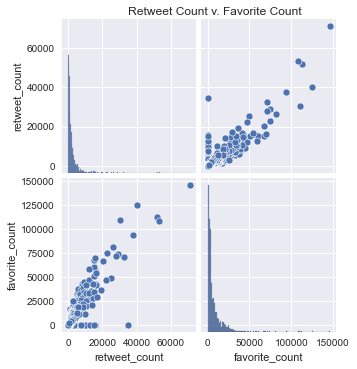

In [107]:
#Use seaborn pairplot to see if we can visually detect pairwise relationship.
import seaborn as sns
fig = sns.pairplot(df_rate[['retweet_count', 'favorite_count']])
fig.fig.suptitle('Retweet Count v. Favorite Count', y=1.01,x=0.6)
fig.savefig('./reports/pairwise.jpg')


In [108]:
#Perform a regression on the dog_category with rating as a response.
df_rate = df_master[['rating', 'dog_category']].copy()
df_dummies = df_rate.dog_category.str.get_dummies(sep=',')
df_rate[list(df_dummies.columns)] = df_dummies
df_rate['intercept'] = 1

lm = sm.OLS(df_rate.rating, df_rate[['intercept', 'doggo', 'floofer', 'pupper', 'puppo']])


print(lm.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     7.120
Date:                Sun, 13 Mar 2022   Prob (F-statistic):           1.11e-05
Time:                        18:53:30   Log-Likelihood:                 435.93
No. Observations:                1682   AIC:                            -861.9
Df Residuals:                    1677   BIC:                            -834.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.0774      0.005    217.873      0.0

In [109]:
#Check top dog breeds (by rating) with simple sorted list
df_rate = df_master[['rating', 'breed_prediction']]
breed_counts = df_rate.breed_prediction.value_counts()
breed_counts = list(breed_counts[(breed_counts > 10)].index)
df_rate = df_rate.query(f'breed_prediction in {breed_counts}')
df_rate

df_rate.groupby('breed_prediction').mean().sort_values(by='rating', ascending=False)

,rating
breed_prediction,
Samoyed,1.173171
golden_retriever,1.172131
Great_Pyrenees,1.146667
chow,1.141667
Pembroke,1.141053
Eskimo_dog,1.140909
cocker_spaniel,1.133333
kelpie,1.130769
Blenheim_spaniel,1.127273


### Insights:
1. Favorite_count and retweet_count have a positive correlation for the response rating. 

2. Doggos and puppos have a strong probability of a positive correlation for response rating.

3. The top 5 rated dogs (as detected) were Pomeranian, Samoyed, golden_retriever, kuvasz, great pyrenees, in that order.


### Visualization

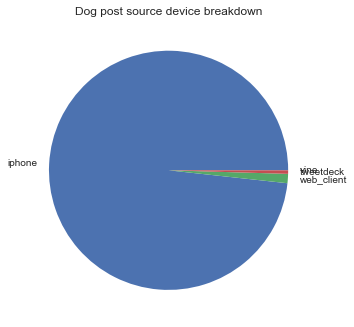

In [110]:
#A pie graph of the source device breakdown:
devices = df_master.source_device.value_counts()
plt.pie(devices.values, labels=list(devices.index))
plt.title('Dog post source device breakdown')
plt.savefig('./reports/source_device_breakdown.jpg')

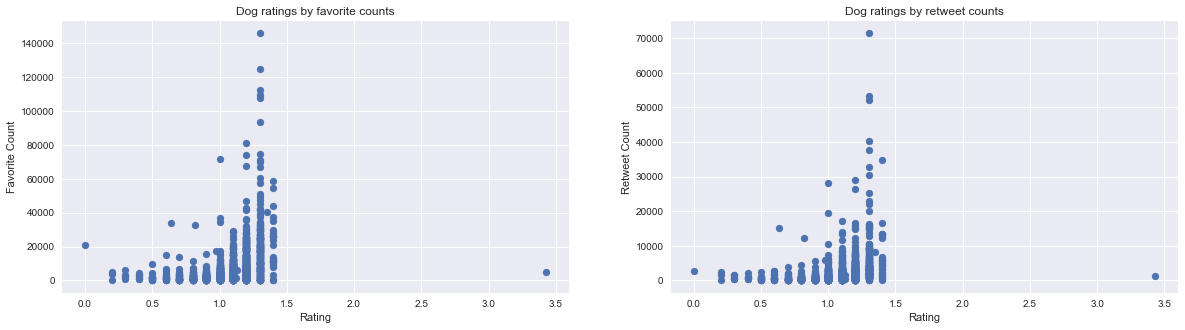

In [111]:
plt.style.use('seaborn')

plt.figure(figsize=(20,5))

#A scatter of the favorited_counts by rating:
plt.subplot(1, 2, 1)
plt.scatter(df_master.rating, df_master.favorite_count)
plt.xlabel('Rating')
plt.ylabel('Favorite Count')
plt.title('Dog ratings by favorite counts')

#A scatter of the retweet_counds by rating:
plt.subplot(1, 2, 2)
plt.scatter(df_master.rating, df_master.retweet_count)
plt.xlabel('Rating')
plt.ylabel('Retweet Count')
plt.title('Dog ratings by retweet counts')


plt.savefig('./reports/scatter-retweets-favorites.jpg')


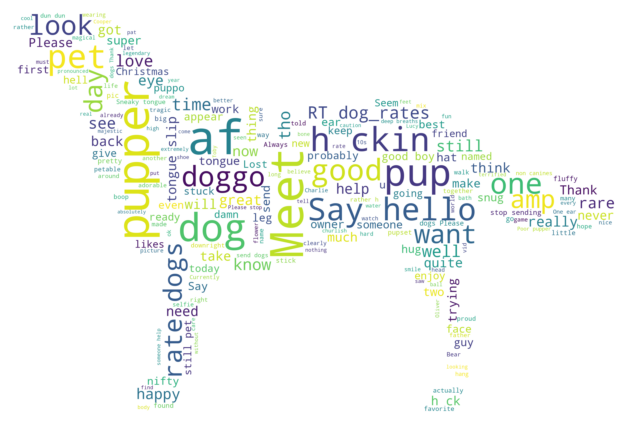

In [112]:
#A wordcloud 

#create a dog image mask
dog_mask = np.array(Image.open("dog_sample_01.png"))
dog_mask[dog_mask == 0] = 255

sw=STOPWORDS

text = ' '.join(df_master.text)
text = re.sub(r"http\S+", "", text)

# # Create and generate a word cloud image:
wordcloud = WordCloud(background_color="white",stopwords=sw, mask=dog_mask).generate(text)

# Display the generated image:
plt.figure(figsize=(11,10))

plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()
wordcloud.to_file('./reports/dogcloud.jpg');


We will make a mosaic out of the dog pictures that we are able to retrieve.

In [113]:
#Download the dog pics
from os.path import exists

#iterate over jpg_urls
for idx,jpg_url in enumerate(tqdm(df_master.jpg_url.values,desc="Retrieving sweet dog pics...", file=sys.stdout)):  
    tweet_id = df_master.tweet_id.values[idx]
    #check if the dog has already been downloaded
    if not exists(f'.\dog_pics\\{tweet_id}.jpg'):
        response = requests.get(jpg_url)
        #if there is a good http response code, write the content to memory by tweet_id.jpg
        if response.status_code == 200:
            with open(f'.\dog_pics\\{tweet_id}.jpg', 'wb') as f:
                f.write(response.content)
        else:
            print(f'Error, response code: {response.status_code}')



Retrieving sweet dog pics...: 100%|██████████████████████████████████████████████| 1682/1682 [00:00<00:00, 2687.88it/s]


In [ ]:
#Now, creating the mosaic itself

#Using tutorial in https://towardsdatascience.com/how-to-create-a-photo-mosaic-in-python-45c94f6e8308

import glob
from PIL import Image
from scipy import spatial
import numpy as np



# Sources and settings
main_photo_path = f".\dog_sample_02.jpg"
tile_photos_path = ".\dog_pics\\*"
tile_size = (50, 50)

# Get all tiles
tile_paths = []
for file in glob.glob(tile_photos_path):
	tile_paths.append(file)


    
# Import and resize all tiles
tiles = []
for path in tile_paths:
	tile = Image.open(path)
	tile = tile.resize(tile_size)
	tiles.append(tile)


# Calculate dominant color
colors = []
for tile in tiles:
	mean_color = np.array(tile).mean(axis=0).mean(axis=0)
	colors.append(mean_color)

# Pixelate (resize) main photo
main_photo = Image.open(main_photo_path)

width = int(np.round(main_photo.size[0] / tile_size[0]))
height = int(np.round(main_photo.size[1] / tile_size[1]))

resized_photo = main_photo.resize((width, height))


# Find closest tile photo for every pixel

# Create a KDTree
tree = spatial.KDTree(colors)

# Empty integer array to store indices of tiles
closest_tiles = np.zeros((width, height), dtype=np.uint32)

for i in range(width):
    for j in range(height):

        pixel = resized_photo.getpixel((i, j))  # Get the pixel color at (i, j)
        closest = tree.query(pixel)             # Returns (distance, index)
        closest_tiles[i, j] = closest[1]        # We only need the index


# Create an output image
output = Image.new('RGB', main_photo.size)

# Draw tiles
for i in range(width):
	for j in range(height):
		# Offset of tile
		x, y = i*tile_size[0], j*tile_size[1]
		# Index of tile
		index = closest_tiles[i, j]
		# Draw tile
		output.paste(tiles[index], (x, y))

# Save output
output.save("./reports/dogsaic.jpg")
display(output);